# Unit Testing Optimisation

## Importing the Packages

In [1029]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

import time

In [1030]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

## Defining SE Covariance

In [1031]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [1032]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

In [1033]:
Vec_SE = jit(vmap(vmap(Squared_exp, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

## Creating Test Data

In [1034]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [1035]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [1036]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 5.0

# Maximum index of input data
k = np.floor(x_maxt/time_bin).astype(np.int64)

xtime = np.linspace(0.0, x_maxt, k + 1)

xtest = random.bernoulli(subkeyx, 0.1, (k+1,)).astype(np.float64)

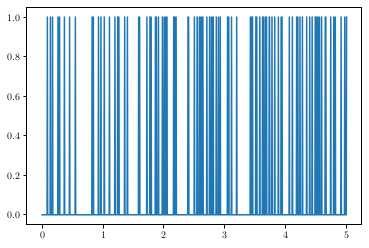

In [1037]:
plt.plot(xtime, xtest)

### True Filter

In [1038]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 0.75

# Maximum index of filter data
n = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, n + 1)

# Damped frequency
w_d = 35.0

# Sqrt True rise rate
tau_rise = np.sqrt(0.1)

# Sqrt True diff
tau_diff = np.sqrt(0.02)

# True lag
lag = 0.03

env_true = AlpEnvelope(ftime, tau_rise, tau_diff, lag)

# Envelope peak
sqtr = tau_rise ** 2
sqtd = sqtr + tau_diff ** 2
tmax = (np.log(sqtr / sqtd) * sqtd * sqtr) / (sqtr - sqtd)

ftrue = np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))) * env_true

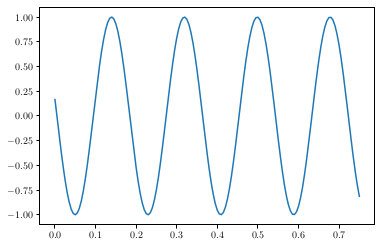

In [1039]:
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

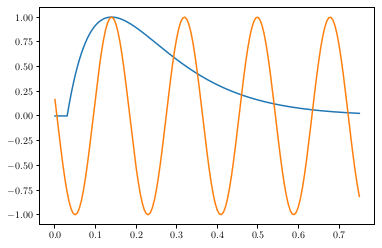

In [1040]:
plt.plot(ftime, env_true)
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

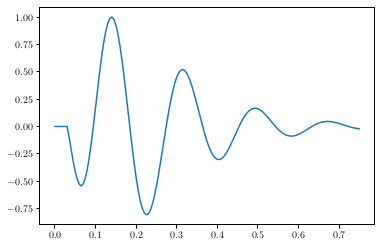

In [1041]:
plt.plot(ftime, ftrue)

### True Noise

In [1042]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.05

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (k + 1,))

### Output

In [1043]:
# Padding and applying the FFT
xpad = np.append(xtest, np.zeros(n))
fpad = np.append(ftrue, np.zeros(k))

x_fft = np.fft.rfft(xpad)
f_fft = np.fft.rfft(fpad)

fftmul = x_fft * f_fft

ynonoise = np.fft.irfft(fftmul, n + k + 1)[:k + 1]

ytest = ynonoise + noise_vec
ytime = np.linspace(0.0, x_maxt, k + 1)

In [1044]:
# Showing equals the raw convolution
yffttest = np.convolve(xtest, ftrue)[:k + 1] + noise_vec

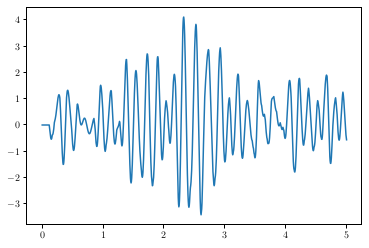

In [1045]:
plt.plot(ytime, ynonoise)

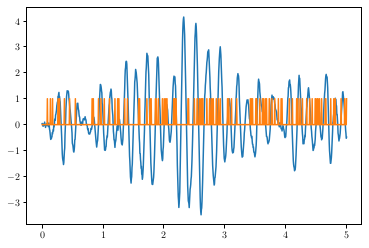

In [1046]:
plt.plot(ytime, ytest)
plt.plot(xtime, xtest)

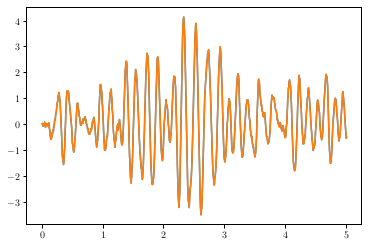

In [1047]:
plt.plot(ytime, yffttest)
plt.plot(ytime, ytest)

## Variational Inference

### ELBO

#### Kl Divergence Term

In [1048]:
@jit
def KL_Term(L_Matrix, V_Vector, M):
  return 0.5 * (- jnp.sum(jnp.log(jnp.diag(L_Matrix) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - M)

#### Log-Likelihood

In [1049]:
@partial(jit, static_argnums = (2, 3, ))
def Log_Likelihood(F_Pad, Sigma_n, N, K, Y_Test, X_Fft):

  F_Fft = jnp.fft.rfft(F_Pad)

  Mean = jnp.fft.irfft(X_Fft * F_Fft, N + K + 1)[: K + 1]
  
  return - 0.5 * ((K + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                  jnp.sum((Y_Test - Mean)**2)/(Sigma_n ** 2))

In [1050]:
Vec_LL = jit(vmap(Log_Likelihood, in_axes = [1, None, None, None, None, None]),
             static_argnums = (2,3,))

#### Expected Log-Likelihood

In [1051]:
@partial(jit, static_argnums = range(9,13))
def Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag, Number_F,
                  M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey):

  K_MM = Vec_SE(Z_Vector, Z_Vector, Sigma_f, Ell)
  K_MN = Vec_SE(Z_Vector, F_Time, Sigma_f, Ell)
  C = jnp.linalg.cholesky(K_MM + 1e-6 * jnp.eye(M)) 
  K_NN = Vec_SE(F_Time, F_Time, Sigma_f, Ell)
  
  B = jsc.linalg.solve_triangular(C, K_MN, lower = True)

  BT = B.T

  Mu_q = B.T @ V_Vector

  V_q = K_NN + BT @ (L_Matrix @ L_Matrix.T - jnp.eye(M)) @ B

  Chol_Vq = jnp.linalg.cholesky(V_q + 1e-6 * jnp.eye(N + 1))

  F_Samples = (Mu_q + Chol_Vq @ random.normal(Subkey, (N + 1, Number_F))) * AlpEnvelope(F_TimeT, TRise, TauDiff, Lag)

  F_Samples = jnp.vstack((F_Samples, jnp.zeros((K, Number_F))))

  Likelihoods = Vec_LL(F_Samples, Sigma_n, N, K, Y_Test, X_Fft)

  return jnp.mean(Likelihoods)

In [1052]:
test_number_f = 100
test_m = int(1000)
test_key = random.PRNGKey(0)
test_sigma_f = 1.0
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = np.linspace(0.0, ftime[-1], test_m)
test_v_m = np.zeros(test_m).reshape((test_m, 1))
test_l_mm = np.eye(test_m)
test_trise = 0.02
test_tdecay = 0.03
test_lag = 0.01

In [1053]:
print(Expected_Term(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_mm, test_trise, test_tdecay, test_lag, test_number_f, test_m, n, k, ytest, x_fft, ftime, ftime.reshape((n + 1, 1)), test_key))

-316763.1262796004


#### ELBO

In [1054]:
@partial(jit, static_argnums = range(10, 14))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise, TauDiff, Lag, Number_F,
         M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey):
         
  Lag = Lag ** 2.0
  # Shift = (Lag // Bin) * Bin
  Square_Frac = Z_Fractions ** 2.0
  Z_Vector = Square_Frac * (F_Time[-1] - Lag) + Lag

  D = jnp.diag(jnp.exp(L_Diag))

  L_Matrix = (D + jnp.zeros((M, M))).at[jnp.tril_indices(M, -1)].set(L_ODiag)

  KL = KL_Term(L_Matrix, V_Vector, M)
  Exp = Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag, Number_F,
                  M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  
  return (KL-Exp)/(K + 1)

In [1055]:
test_number_f = 100
test_m = 200
test_key = random.PRNGKey(0)
test_sigma_f = 2.0
test_ell_f = 0.7
test_sigma_n = 0.01
test_z_m = np.linspace(0.0, ftime[-1], test_m)
test_v_m = 5.0 * np.ones((test_m, 1))
test_l_diag = np.ones(test_m)
test_l_odiag = np.tril(np.zeros((test_m, test_m)), -1)[np.tril_indices(test_m, -1)]
test_trise = 0.02
test_tdecay = 0.03
test_lag = 0.01

In [1056]:
print(Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_diag, test_l_odiag, test_trise, test_tdecay, test_lag, test_number_f, test_m, n, k, ytest, x_fft, ftime, ftime.reshape((n + 1, 1)), test_key))

8062.0816616319535


In [1057]:
Grad_Bound = jit(value_and_grad(Neg_ELBO, argnums = range(10)), static_argnums = range(10, 14))

### Optimiser

#### Sub-function Definitions

In [1058]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [1059]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [1060]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [1061]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [1062]:
@jit
def CFinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [1063]:
@jit
def MFinState(X, Mhat, Vhat, Step_Size = 1e-3, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [1064]:
@jit
def FFinState(X, Mhat, Vhat, Step_Size = 1e-4, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [1065]:
@jit
def CAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(CFinState, X, Mhat, Vhat)

  return X, M, V

In [1066]:
@jit
def MAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(MFinState, X, Mhat, Vhat)

  return X, M, V

In [1067]:
@jit
def FAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(FFinState, X, Mhat, Vhat)

  return X, M, V

In [1068]:
@partial(jit, static_argnums = range(12,16))
def _CUpdate(Iter, X, Subkey, Key, ELBO_History, Step, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT,
             Num_Coarse_Fs, M, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = CAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkey, Key, ELBO_History, Step, Mad, Vad)

In [1069]:
@partial(jit, static_argnums = range(12,16))
def _MUpdate(Iter, X, Subkey, Key, ELBO_History, Step, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT,
             Num_Coarse_Fs, M, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = MAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkey, Key, ELBO_History, Step, Mad, Vad)

In [1070]:
@partial(jit, static_argnums = range(12,16))
def _FUpdate(Iter, X, Subkey, Key, ELBO_History, Step, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT,
             Num_Coarse_Fs, M, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = FAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkey, Key, ELBO_History, Step, Mad, Vad)

#### Adam Function Definition

In [1071]:
@partial(jit, static_argnums = range(5, 9))
def AdamOpt(Init_Params, X_Fft, Y_Test, F_Time, F_TimeT, M, N, K, Num_Fs,              
                        Coarse_Schedule = jnp.asarray([400, 400, 700, 1000, 1000]), Mid_Schedule = jnp.asarray([13500]),
                        Fine_Iters = 1000):
  
  """
  Function implementing the Adam optimiser loop.
  """
  ELBO_History = jnp.zeros(17000)
  Step = 0
  Mad = tree_map(jnp.zeros_like, Init_Params)
  Vad = tree_map(jnp.zeros_like, Init_Params)
  Key = random.PRNGKey(1)
  Key, Subkey = random.split(Key)
  Params = Init_Params

  def CUpdate(Iter, State):
    return _CUpdate(Iter, *State, Y_Test, X_Fft, F_Time, F_TimeT, Num_Fs, M, N, K)

  def MUpdate(Iter, State):
    return _MUpdate(Iter, *State, Y_Test, X_Fft, F_Time, F_TimeT, Num_Fs, M, N, K)

  def FUpdate(Iter, State):
    return _FUpdate(Iter, *State, Y_Test, X_Fft, F_Time, F_TimeT, Num_Fs, M, N, K)

  JCUpdate = jit(CUpdate)
  JMUpdate = jit(MUpdate)
  JFUpdate = jit(FUpdate)

  def CReset(Iter, State):
    InOptState = lax.fori_loop(0, Coarse_Schedule[Iter], JCUpdate, State)
    return InOptState

  def MReset(Iter, State):
    InOptState = lax.fori_loop(0, Mid_Schedule[Iter], JMUpdate, State)
    return InOptState

  JCReset = jit(CReset)
  JMReset = jit(MReset)

  OptState = lax.fori_loop(0, len(Coarse_Schedule), JCReset, (Params, Subkey, Key, ELBO_History, Step, Mad, Vad))

  OptState = lax.fori_loop(0, len(Mid_Schedule), JMReset, OptState)

  OptState = lax.fori_loop(0, Fine_Iters, JFUpdate, OptState)

  return OptState[0], OptState[-4]

In [1072]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 6.0
iell = 0.002
isigma_n = 0.0005


itrise = np.sqrt(0.05)
itaudiff = np.sqrt(0.04)
ilag = np.sqrt(0.0001)

# Variational parameters
num_ind = 30
iz_fracs = [0.0]
for i in range(num_ind - 1):
  iz_fracs.append(np.sqrt(iz_fracs[i]**2 + 1/num_ind))
iz_fracs = jnp.asarray(iz_fracs)
key, *subkeys = random.split(key, 4)
iv_vector = (jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-3], (num_ind,))).reshape((num_ind, 1))
il_diag = jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-2], (num_ind,))
il_odiag = jnp.zeros(int((num_ind ** 2 - num_ind) / 2)) + \
            0.1 * random.normal(subkeys[-1], (int((num_ind ** 2 - num_ind) / 2),))
num_f = 100
ftimet = ftime.reshape((n + 1, 1))

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, opt_subkey = random.split(opt_key)

params = (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag)
consparams = (num_ind, n, k, ytest, x_fft, ftime, ftimet)

In [1073]:
fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, ftimet, num_ind, n, k, num_f)

In [1074]:
# %%timeit
# fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, ftimet, num_ind, n, k, num_f)

In [1075]:
print(Neg_ELBO(*params, num_f, *consparams, opt_subkey))

178360192.45383447


In [1076]:
print(Neg_ELBO(*fparams, num_f, *consparams, opt_subkey))

-0.5404914810918267


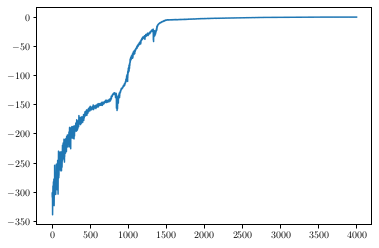

In [1077]:
plt.plot(elbo_history[1000:5000])

In [1078]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = fparams

In [1079]:
flag = flag ** 2
ilag = ilag ** 2
flag = (flag // time_bin) * time_bin
ilag = (ilag // time_bin) * time_bin
print(ilag)

0.0


In [1080]:
fv_vector = fv_vector.flatten()
iv_vector = iv_vector.flatten()

In [1081]:
print(fsigma_f)

5.978975936970911


In [1082]:
print(fell)

-0.08614554918504688


In [1083]:
print(fsigma_n)

0.12969891943253506


In [1084]:
print(ftrise)

0.01080453840806935


In [1085]:
print(ftaudiff)

0.37044720767128386


In [1086]:
print(flag)

0.045


In [1087]:
fsquares = fz_fracs ** 2
fz_vector = fsquares * (ftime[-1] - flag) + flag
isquares = iz_fracs ** 2
print(iz_fracs)
print(isquares)
iz_vector = isquares * (ftime[-1] - ilag) + ilag

[0.         0.18257419 0.25819889 0.31622777 0.36514837 0.40824829
 0.4472136  0.48304589 0.51639778 0.54772256 0.57735027 0.60553007
 0.63245553 0.65828059 0.68313005 0.70710678 0.73029674 0.75277265
 0.77459667 0.79582243 0.81649658 0.83666003 0.85634884 0.87559504
 0.89442719 0.91287093 0.93094934 0.9486833  0.96609178 0.98319208]
[0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


In [1088]:
d = np.diag(np.exp(fl_diag))

fl_matrix = d + np.zeros(num_ind)
fl_matrix[np.tril_indices(num_ind, -1)] = fl_odiag

## Variational Predictions

In [1089]:
fpred_points = ftime.copy()

In [1090]:
ikmm = Vec_SE(iz_vector, iz_vector, isigma_f, iell)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Vec_SE(iz_vector, fpred_points, isigma_f, iell)
ibast = sc.linalg.solve_triangular(icpred, ikzast, lower = True)
icov_pred = Vec_SE(fpred_points, fpred_points, isigma_f, iell) + \
           ibast.T @ (fl_matrix @ fl_matrix.T - np.eye(num_ind)) @ ibast
imean_pred = iv_vector @ ibast
ienv = AlpEnvelope(ftime, itrise, itaudiff, ilag)
ienvind = AlpEnvelope(iz_vector, itrise, itaudiff, ilag)
imean_pred *= ienv

In [1091]:
kmm = Vec_SE(fz_vector, fz_vector, fsigma_f, fell)
cpred = np.linalg.cholesky(kmm + 1e-6 * np.eye(num_ind))
kzast = Vec_SE(fz_vector, fpred_points, fsigma_f, fell)
bast = sc.linalg.solve_triangular(cpred, kzast, lower = True)
cov_pred = Vec_SE(fpred_points, fpred_points, fsigma_f, fell) + \
           bast.T @ (fl_matrix @ fl_matrix.T - np.eye(num_ind)) @ bast
mean_pred = fv_vector @ bast
fenv = AlpEnvelope(ftime, ftrise, ftaudiff, flag)
fenvind = AlpEnvelope(fz_vector, ftrise, ftaudiff, flag)
mean_pred *= fenv

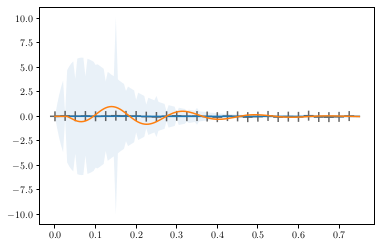

In [1092]:
plt.plot(fpred_points, imean_pred)
plt.plot(ftime, ftrue)
is2 = np.sqrt(np.diag(icov_pred))
ifill = (imean_pred - is2 * ienv, imean_pred + is2 * ienv)
plt.fill_between(fpred_points, *ifill, alpha = 0.1)
plt.scatter(iz_vector, iv_vector @ icpred.T, s = 100, marker = '+', c='k', alpha = 0.6)

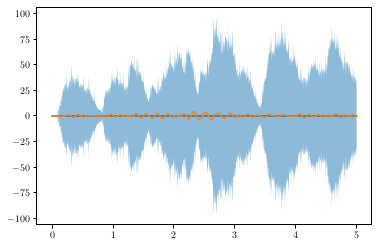

In [1093]:
plt.plot(ytime, np.convolve(xtest, imean_pred)[: k + 1])
plt.plot(ytime, ytest)   
plt.fill_between(ytime, np.convolve(xtest, imean_pred - 2*is2*ienv)[: k + 1] - 2* isigma_n,
                    np.convolve(xtest, imean_pred + 2*is2*ienv)[: k + 1] + 2* isigma_n, alpha = 0.5)                 

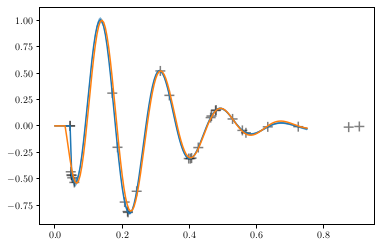

In [1096]:
plt.plot(fpred_points, mean_pred)
plt.plot(ftime, ftrue)
s2 = np.sqrt(np.diag(cov_pred))
fill = (mean_pred - 2*s2*fenv, mean_pred + 2*s2*fenv)
plt.fill_between(fpred_points, *fill, alpha = 0.6)
plt.scatter(fz_vector, (fv_vector @ cpred.T) * fenvind, s = 100, marker = '+', c='k', alpha = 0.5)
#plt.xlim([0.0, ftime[-1]])

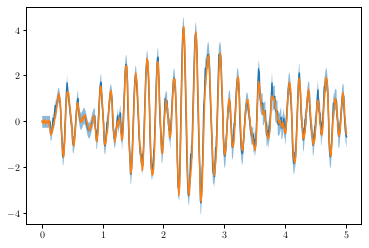

In [1095]:
plt.plot(ytime, np.convolve(xtest, mean_pred)[: k + 1])
plt.plot(ytime, ytest)
plt.fill_between(ytime, np.convolve(xtest, mean_pred - 2*s2*fenv)[: k + 1] - 2* fsigma_n,
                    np.convolve(xtest, mean_pred + 2*s2*fenv)[: k + 1] + 2* fsigma_n, alpha = 0.5)                  